<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Build/blob/main/OnlineNewsPopularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/nsriniva/DS-Unit-2-Build/master/'
    '''
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap
    '''
# If you're working locally:
else:
    DATA_PATH = '../data/'

from collections import OrderedDict
from math import isclose
import zipfile 
from urllib.request import urlopen
import io

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


# For details about the data cleanup, please see 
# https://github.com/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/CleanupOnlineNewsPopularity.ipynb
# and 'The Dataset' section of
# https://nsriniva.github.io/2020-10-23-DSPT9-Unit1-BuildProject/

# Cleaned up and uploaded csv data file from 
# https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip 
# in
# https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity
# to my github repo as
# https://github.com/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/OnlineNewsPopularity.csv.zip?raw=true

# The associated names file is available at
# https://raw.githubusercontent.com/nsriniva/DS-Unit-2-Applied-Modeling/master/OnlineNewsPopularity.names


onp_url = DATA_PATH + 'OnlineNewsPopularity.csv.zip'

onp_df = pd.read_csv(onp_url, compression='zip')

null_values = onp_df.isna().sum().sum()

print(f"There are {['','no'][int(null_values==0)]} invalid values in the dataset!")

# The zscore() method from the scipy.stats package is used to compute z scores 
# for the shares values. These z scores is compared against the specified  
# sigma value to generate a boolean filter array that could be used to 
# paritition the dataset based on whether the zscore is greater than the
# specified sigma.
def get_sigma_filter(df, sigma=0.5):
  z = np.abs(stats.zscore(df.shares))
  return np.where(z>sigma)[0]

# Use the boolean filter array provided by get_sigma_filter() to
# ignore entries with zscore greater than 0.5 and compute the
# median and max 'shares' values for the remaining entries.
def classification_marks(df):

  shares_info = df.drop(get_sigma_filter(df)).shares

  max = shares_info.max()
  median = shares_info.median()

  return median, max


shares_median = onp_df.shares.median()

print(shares_median)
# Use the medium(median) value to classify articles into 
# unpopular(0) and popular(1)  
onp_df['popularity'] = onp_df.shares.apply(lambda x: 0 if x < shares_median else 1)

display(onp_df.shape)

# Remove outliers
def remove_outliers(df, sigma=0.5):
  df = df.copy()
  return df.drop(get_sigma_filter(df, sigma))


onp_no_df = onp_df.copy()

#onp_no_df = remove_outliers(onp_no_df, 0.25)

shares_median = onp_no_df.shares.median()

print(shares_median)

# Use the medium(median) value to classify articles into 
# unpopular(0) and popular(1)  
onp_no_df['popularity'] = onp_no_df.shares.apply(lambda x: 0 if x < shares_median else 1)

display(onp_no_df.shape)



# The baseline accuracy or the value we'd get by just guessing that that the
# value is always the majority class

target = 'popularity'

baseline_accuracy = onp_no_df[target].value_counts(normalize=True).max()

print(f'baseline_accuracy = {baseline_accuracy:0.4f}')

# Drop the 'shares' column used to derive 'popularity' along
# with the non predictive 'url' and 'timedelta' columns.
drop_cols = ['shares', 'url', 'timedelta']

onp_no_df = onp_no_df.drop(columns=drop_cols)
# Will use a random split of 64% Training, 16% Validation and 20% Test 

X = onp_no_df.drop(columns=target)
y = onp_no_df[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,train_size=0.8, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=42)

display(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

display(y_train.value_counts(normalize=True))
baseline_accuracy = y_train.value_counts(normalize=True).max()

print(f'baseline_accuracy = {baseline_accuracy:0.4f}')




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

There are no invalid values in the dataset!
1400.0


(39644, 51)

1400.0


(39644, 51)

baseline_accuracy = 0.5336


(25372, 47)

(6343, 47)

(7929, 47)

(25372,)

(6343,)

(7929,)

1    0.536891
0    0.463109
Name: popularity, dtype: float64

baseline_accuracy = 0.5369


In [16]:
def model_acc_auc(model, X_tr, y_tr, X_v, y_v):
  tr_acc = model.score(X_tr, y_tr)
  v_acc = model.score(X_v, y_v)

  y_tr_proba = model.predict_proba(X_tr)[:, -1] # Probability for the last class

  tr_auc = roc_auc_score(y_tr, y_tr_proba)

  y_v_proba = model.predict_proba(X_v)[:, -1] # Probability for the last class

  v_auc = roc_auc_score(y_v, y_v_proba)

  return tr_acc, tr_auc, v_acc, v_auc

In [2]:
# Simple model, with OrdinalEncoder for the data_channel and weekday categorical
# columns and a DecisionTreeClassifier with default parameter values.
model = make_pipeline(
  OrdinalEncoder(), 
  DecisionTreeClassifier()
)

model.fit(X_train, y_train)

display(y_train.value_counts(normalize=True))
display(y_val.value_counts(normalize=True))

training_bl = y_train.value_counts(normalize=True).max()
validation_bl = y_val.value_counts(normalize=True).max()

training_acc =  model.score(X_train, y_train)
validation_acc =  model.score(X_val, y_val)


print(f'Training Accuracy:{training_acc:0.4f}/{training_bl:0.4f}')
print(f'Validation Accuracy:{validation_acc:0.4f}/{validation_bl:0.4f}')

transformers = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=103, random_state=42, n_jobs=-1, max_depth=25, min_samples_leaf=3, max_features=0.3)
model.fit(X_train_transformed, y_train)

training_acc =  model.score(X_train_transformed, y_train)
validation_acc =  model.score(X_val_transformed, y_val)


print(f'Training Accuracy:{training_acc:0.4f}/{training_bl:0.4f}')
print(f'Validation Accuracy:{validation_acc:0.4f}/{validation_bl:0.4f}')


permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)


1    0.536891
0    0.463109
Name: popularity, dtype: float64

1    0.532398
0    0.467602
Name: popularity, dtype: float64

Training Accuracy:1.0000/0.5369
Validation Accuracy:0.5876/0.5324
Training Accuracy:0.9961/0.5369
Validation Accuracy:0.6677/0.5324


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=25,
                                                       max_features=0.3,
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=3,
                                                       min_samples_split=2,
                                                       min_weight_fractio

In [3]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0207 ± 0.0071,kw_avg_avg
0.0191 ± 0.0063,is_weekend
0.0091 ± 0.0041,self_reference_min_shares
0.0085 ± 0.0022,data_channel
0.0057 ± 0.0028,kw_max_avg
0.0051 ± 0.0012,LDA_01
0.0050 ± 0.0026,LDA_04
0.0034 ± 0.0024,kw_avg_min
0.0032 ± 0.0019,n_tokens_content
0.0025 ± 0.0022,kw_min_avg


In [4]:
print('Shape before removing', X_train.shape)

minimum_importance = 0 
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

print('Shape after removing ', X_train.shape)

X_val = X_val[features]
X_test = X_test[features]

Shape before removing (25372, 47)
Shape after removing  (25372, 29)


In [5]:
model = make_pipeline(
  OrdinalEncoder(), 
  DecisionTreeClassifier(max_depth=7,random_state=42, min_samples_leaf=3)
)

model.fit(X_train, y_train)

display(y_train.value_counts(normalize=True))
display(y_val.value_counts(normalize=True))

training_bl = y_train.value_counts(normalize=True).max()
validation_bl = y_val.value_counts(normalize=True).max()

training_acc =  model.score(X_train, y_train)
validation_acc =  model.score(X_val, y_val)


print(f'Training Accuracy:{training_acc:0.4f}/{training_bl:0.4f}')
print(f'Validation Accuracy:{validation_acc:0.4f}/{validation_bl:0.4f}')

1    0.536891
0    0.463109
Name: popularity, dtype: float64

1    0.532398
0    0.467602
Name: popularity, dtype: float64

Training Accuracy:0.6688/0.5369
Validation Accuracy:0.6413/0.5324


In [6]:
pipe_elems = (
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=103, random_state=42, n_jobs=-1, max_depth=25, min_samples_leaf=3, max_features=0.3)
)

pipe = make_pipeline(
  *pipe_elems
)


# Fit on train, score on val
pipe.fit(X_train, y_train)
print('Validation Accuracy', pipe.score(X_val, y_val))
print('Test Accuracy', pipe.score(X_test, y_test))

Validation Accuracy 0.6697146460665301
Test Accuracy 0.6616218943120191


In [7]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model = XGBClassifier(n_estimators=1000, random_state=42, n_jobs=-1, max_depth=6, learning_rate=0.5) 

eval_metric = 'auc'
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric=eval_metric,
          early_stopping_rounds=400)


[0]	validation_0-auc:0.709981	validation_1-auc:0.682634
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 400 rounds.
[1]	validation_0-auc:0.731751	validation_1-auc:0.694311
[2]	validation_0-auc:0.746126	validation_1-auc:0.701934
[3]	validation_0-auc:0.754897	validation_1-auc:0.70736
[4]	validation_0-auc:0.765862	validation_1-auc:0.712965
[5]	validation_0-auc:0.773346	validation_1-auc:0.714604
[6]	validation_0-auc:0.781319	validation_1-auc:0.717236
[7]	validation_0-auc:0.78573	validation_1-auc:0.718506
[8]	validation_0-auc:0.790416	validation_1-auc:0.718838
[9]	validation_0-auc:0.796059	validation_1-auc:0.718526
[10]	validation_0-auc:0.79899	validation_1-auc:0.717766
[11]	validation_0-auc:0.805168	validation_1-auc:0.716605
[12]	validation_0-auc:0.810061	validation_1-auc:0.71523
[13]	validation_0-auc:0.813641	validation_1-auc:0.713919
[14]	validation_0-auc:0.818773	validation_1-auc:0.714256
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

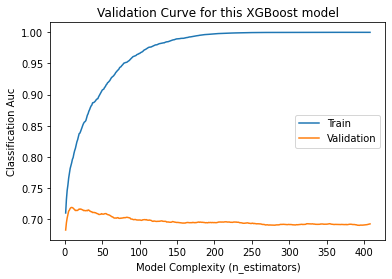

In [8]:
results = model.evals_result()
train_error = results['validation_0'][eval_metric]
val_error = results['validation_1'][eval_metric]
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel(f'Classification {eval_metric.capitalize()}')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

In [9]:
y_pred_proba = model.predict_proba(X_val_encoded)[:, -1] # Probability for the last class

val_roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'Validation ROC AUC score : {model.best_score:0.4f}/{val_roc_auc:0.4f}')

y_pred_proba = model.predict_proba(X_test_encoded)[:, -1] # Probability for the last class

test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Test ROC AUC score : {test_roc_auc:0.4f}')

Validation ROC AUC score : 0.7188/0.7188
Test ROC AUC score : 0.7139


In [10]:
features = ['is_weekend', 'kw_avg_avg']

print(X_train_encoded.shape, X_val_encoded.shape)

isolated = []

for feature in features:
  isolated.append(
      pdp_isolate(
      model=model, 
      dataset=X_val_encoded, 
      model_features=X_val_encoded.columns, 
      feature=feature
    )
  )

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns,
    features=features
)

(25372, 29) (6343, 29)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


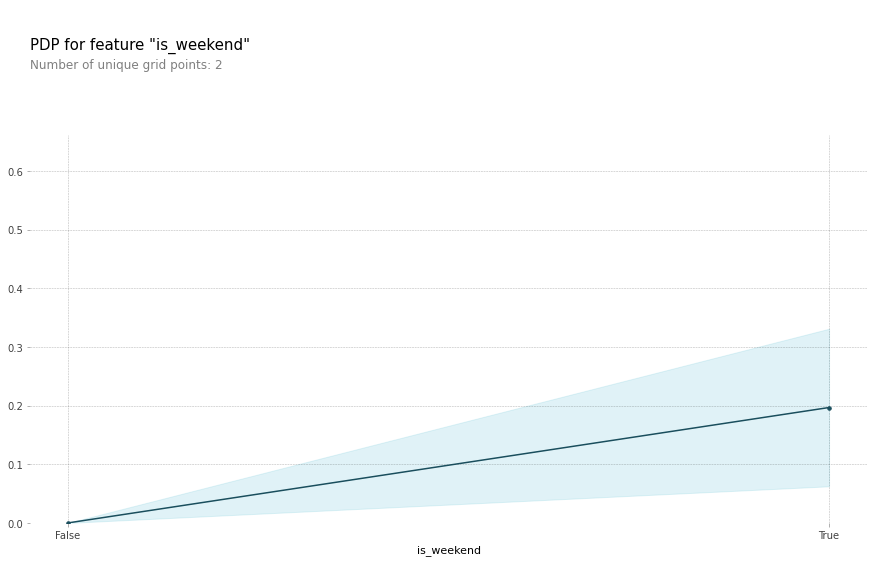

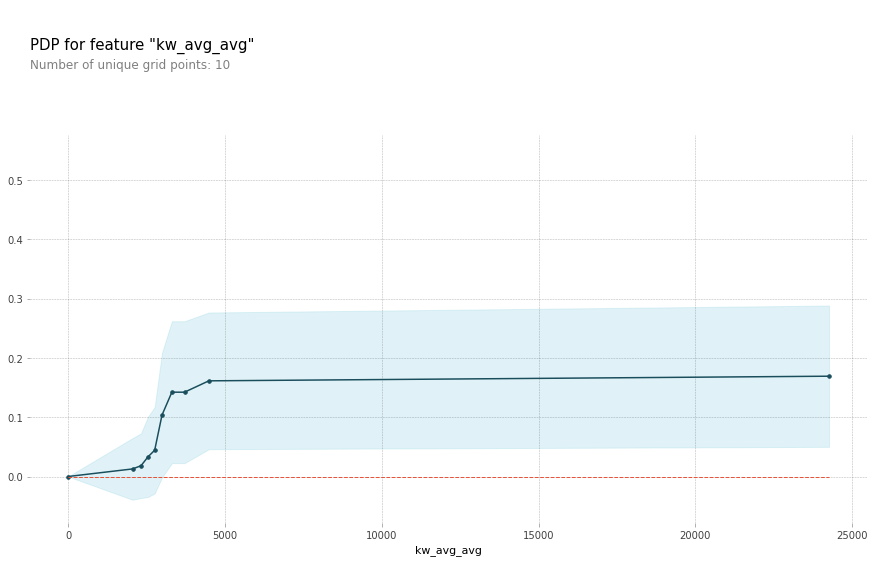

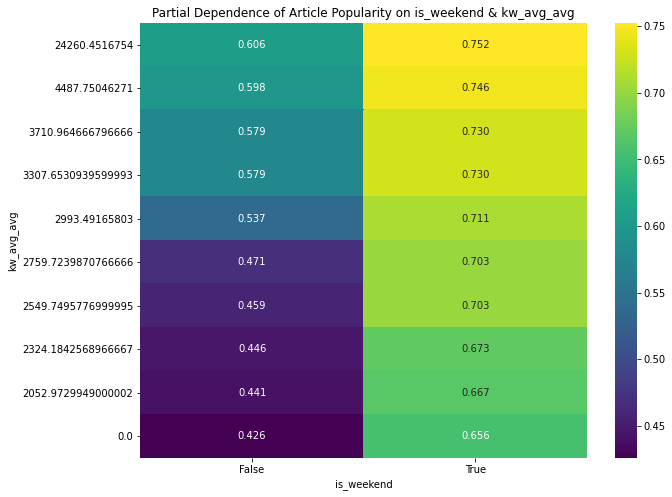

In [11]:
for idx,elem in enumerate(isolated):
  pdp_plot(elem, feature_name=features[idx]);
  if features[idx] == 'is_weekend':
    # Manually change the xticks labels
    plt.xticks([0, 1], ['False', 'True']);

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns={0:'False', 1:'True'})
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.3f', cmap='viridis')
plt.title('Partial Dependence of Article Popularity on is_weekend & kw_avg_avg');


In [12]:
df = pd.DataFrame({
    'pred_proba': y_pred_proba, 
    'popular': y_test
}) 

df= df.merge(X_test_encoded, left_index=True, right_index=True)

popular = df.popular == 1
unpopular = df.popular == 0
popular_right = (popular) == (df['pred_proba'] > 0.50)
unpopular_right = (unpopular) == (df['pred_proba'] <= 0.50)


popular_correct = df[popular&popular_right]
unpopular_correct = df[unpopular&unpopular_right]

correct = df[popular&popular_right | unpopular&unpopular_right]

display(popular_correct.shape, unpopular_correct.shape, correct.shape, df.shape)
display(correct.sample(n=10, random_state=1).sort_values(by='pred_proba'))

row_popular = X_test_encoded.loc[[25641]]

row_unpopular = X_test_encoded.loc[[5864]]

display(row_popular, row_unpopular)

(2952, 31)

(2246, 31)

(5198, 31)

(7929, 31)

,pred_proba,popular,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_keywords,kw_max_min,kw_avg_min,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,is_weekend,LDA_01,LDA_02,LDA_04,avg_positive_polarity,max_positive_polarity,avg_negative_polarity,title_sentiment_polarity,abs_title_subjectivity,data_channel,weekday
35047,0.211214,0,13.0,310.0,0.600707,1.0,0.668394,8.0,1.0,4.0,49.0,11.500000,843300.0,383800.000000,1925.348148,3447.585836,2842.141670,3800.0,3800.0,3800.000000,0.0,0.524852,0.324102,0.050000,0.472857,1.000,-0.345397,0.000000,0.500000,1,4
25641,0.278434,0,11.0,961.0,0.446316,1.0,0.589109,22.0,1.0,6.0,99.0,37.000000,843300.0,376450.000000,1373.760563,3578.376708,2227.211489,2800.0,2800.0,2800.000000,0.0,0.033333,0.866665,0.033335,0.339325,1.000,-0.364744,-0.155556,0.211111,5,6
5557,0.493983,0,8.0,364.0,0.570248,1.0,0.744186,5.0,1.0,7.0,648.0,335.142857,690400.0,294400.000000,2174.476551,4707.312500,3599.435065,711.0,6700.0,2870.333333,0.0,0.029096,0.781941,0.028573,0.400204,0.800,-0.265625,0.000000,0.500000,5,6
5864,0.675591,1,7.0,141.0,0.691176,1.0,0.841463,3.0,1.0,6.0,503.0,292.666667,690400.0,154800.000000,2070.452055,3650.875000,3090.059245,12400.0,12400.0,12400.000000,0.0,0.622510,0.033334,0.277228,0.202273,0.375,-0.100000,0.000000,0.500000,1,2
1513,0.697207,1,10.0,163.0,0.680982,1.0,0.840000,3.0,0.0,7.0,427.0,325.666667,69100.0,29242.857143,0.000000,2895.466667,1817.263903,3400.0,3400.0,3400.000000,0.0,0.029758,0.477988,0.028682,0.287879,0.600,-0.466667,0.500000,0.500000,5,3
19068,0.744087,1,9.0,184.0,0.672131,1.0,0.698413,15.0,10.0,9.0,1200.0,363.111111,843300.0,238577.777778,3100.000000,5967.424162,4369.401880,896.0,896.0,896.000000,0.0,0.022229,0.022288,0.204902,0.686667,1.000,-0.285417,-0.325000,0.150000,7,4
2442,0.748642,1,10.0,344.0,0.646688,1.0,0.722467,18.0,1.0,5.0,382.0,317.800000,69100.0,42820.000000,2405.465839,4201.944444,3061.494741,7500.0,7500.0,7500.000000,0.0,0.040305,0.040265,0.040002,0.204545,0.500,-0.550000,0.000000,0.500000,6,4
33938,0.785316,1,8.0,848.0,0.454869,1.0,0.637827,6.0,1.0,8.0,1100.0,186.857143,843300.0,367612.500000,0.000000,6453.059908,3262.304337,2900.0,9900.0,6400.000000,0.0,0.149864,0.025326,0.774807,0.418934,1.000,-0.396094,0.000000,0.500000,3,3
1179,0.813685,1,6.0,1577.0,0.373410,1.0,0.570447,17.0,1.0,7.0,902.0,484.333333,51900.0,23271.428571,0.000000,4083.666667,2415.247218,27.0,2900.0,1656.500000,0.0,0.028572,0.028602,0.028605,0.411450,1.000,-0.206771,0.000000,0.375000,2,4
24595,0.843319,1,11.0,497.0,0.565032,1.0,0.664740,53.0,25.0,10.0,710.0,276.250000,843300.0,238540.000000,0.000000,8144.031167,3466.987988,1800.0,2000.0,1900.000000,1.0,0.020147,0.020003,0.021423,0.407718,1.000,-0.258485,0.000000,0.500000,4,5


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_keywords,kw_max_min,kw_avg_min,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,is_weekend,LDA_01,LDA_02,LDA_04,avg_positive_polarity,max_positive_polarity,avg_negative_polarity,title_sentiment_polarity,abs_title_subjectivity,data_channel,weekday
25641,11.0,961.0,0.446316,1.0,0.589109,22.0,1.0,6.0,99.0,37.0,843300.0,376450.0,1373.760563,3578.376708,2227.211489,2800.0,2800.0,2800.0,0.0,0.033333,0.866665,0.033335,0.339325,1.0,-0.364744,-0.155556,0.211111,5,6


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_keywords,kw_max_min,kw_avg_min,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,is_weekend,LDA_01,LDA_02,LDA_04,avg_positive_polarity,max_positive_polarity,avg_negative_polarity,title_sentiment_polarity,abs_title_subjectivity,data_channel,weekday
5864,7.0,141.0,0.691176,1.0,0.841463,3.0,1.0,6.0,503.0,292.666667,690400.0,154800.0,2070.452055,3650.875,3090.059245,12400.0,12400.0,12400.0,0.0,0.62251,0.033334,0.277228,0.202273,0.375,-0.1,0.0,0.5,1,2


In [13]:
explainer = shap.TreeExplainer(model)

shap.initjs()

shap_values = explainer.shap_values(row_popular)
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row_popular,
    #matplotlib=True, # This does not work if link is set to 'logit'
    link='logit' # For classification, this shows predicted probabilities
)

  
  

In [14]:
shap.initjs()

shap_values = explainer.shap_values(row_unpopular)
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row_unpopular,
    #matplotlib=True, # This does not work if link is set to 'logit'
    link='logit' # For classification, this shows predicted probabilities
)